<a href="https://colab.research.google.com/github/AyushDiyundi/AI-Scientific-Programming/blob/main/HousingMafia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mafia EDA: The Underground Investor Strategy
### Prepared by: The "Housing Mafia" (Ayush, Elahe, Mohamed, Mariana)

**Objective:** To identify high-utility, low-profile properties in King County for organizational "safe houses" and storage operations, satisfying the "Underground Investor" client scenario.

## Our Strategic Hypotheses (The What, Why, and When)
1. **Basement-to-Value Arbitrage (What & Why):** South King County cities provide more storage (basement sqft) per dollar spent.
2. **Stealth/Privacy Clusters (What & Why):** Specific suburban areas contain high densities of "Hidden Fortresses" (large lots with zero visibility).
3. **Market Timing (When):** There is a distinct seasonal dip in the market, providing an optimal window for aggressive cash acquisitions.
4. **Renovation Laundering (Why):** "Condition 2" properties offer the lowest entry price-per-square-foot for high-cash renovation projects.
5. **Safe House Hubs (Where):** Specific southern zip codes offer tight clusters of affordable, high-capacity homes (4+ beds, 1000+ sqft basement).

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tabulate import tabulate

# Load Dataset
path = "https://raw.githubusercontent.com/AyushDiyundi/AI-Scientific-Programming/main/KC_housing_data.csv"
df = pd.read_csv(path)

# Convert dates to find the best time to buy
df['date'] = pd.to_datetime(df['date'])
df['month'] = df['date'].dt.month

print(f"Data spans from: {df['date'].min().date()} to {df['date'].max().date()}")

# Remove rows where price is 0 to avoid division errors
df = df[df['price'] > 0]

Data spans from: 2014-05-02 to 2014-07-10


## Phase 1: Data Preparation & Feature Engineering
We focus on properties with basements (essential for operations). We create three strategic metrics:
* **Price per Sqft:** To identify undervalued targets.
* **Basement Efficiency:** Sqft of basement per dollar spent.
* **Stealth Flag:** Identifies lots > 10,000 sqft with zero visibility (no view/waterfront).

In [2]:
# 1. Filter: Basements Only & Remove Mansions/Outliers
df_underground = df[df['sqft_basement'] > 0].copy()

# Restoring your excellent outlier filter to prevent graph squishing!
df_clean = df_underground[
    (df_underground['price'] < 2000000) &
    (df_underground['bedrooms'] < 10)
].copy()

# 2. Feature Engineering
# Price per Sqft (Hypothesis 4)
df_clean['price_per_sqft'] = df_clean['price'] / df_clean['sqft_living']

# Basement Efficiency (Hypothesis 1)
df_clean['basement_efficiency'] = np.where(
    df_clean['price'] > 0,
    df_clean['sqft_basement'] / df_clean['price'],
    0
)

## Phase 2: Proving Value and Privacy (The "What" & "Why")
We analyze where we get the most "storage per dollar" and where the most "Hidden Fortresses" are located in outskirt areas.

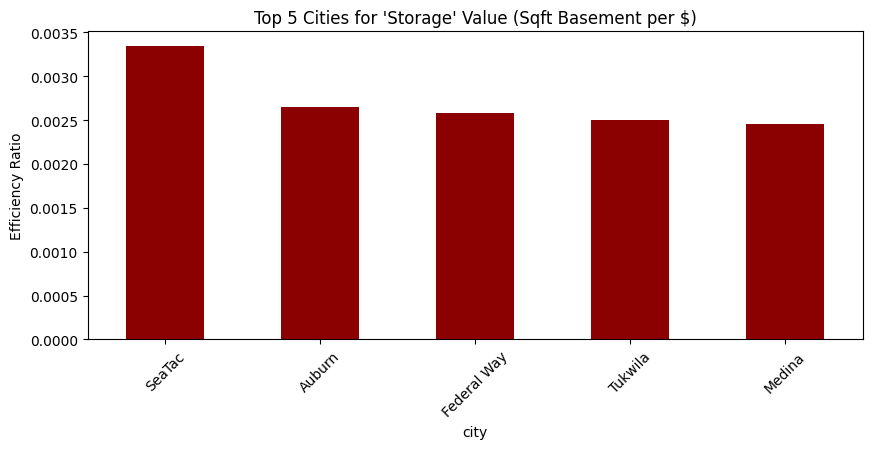

In [3]:
# Hypothesis 1: Basement Efficiency by City
efficiency_stats = df_clean.groupby('city')['basement_efficiency'].mean().sort_values(ascending=False).head(5)

plt.figure(figsize=(10,4))
efficiency_stats.plot(kind='bar', color='darkred')
plt.title("Top 5 Cities for 'Storage' Value (Sqft Basement per $)")
plt.ylabel("Efficiency Ratio")
plt.xticks(rotation=45)
plt.show()

--- STEALTH PROPERTY DENSITY: URBAN VS SUBURBAN ---
Total Stealth Properties in Seattle: 31
Total Stealth Properties in Suburbs: 357

Top 5 Suburban Hubs for 'Hidden Fortresses':
city
Bellevue       59
Issaquah       34
Redmond        28
Sammamish      24
Woodinville    24
Name: count, dtype: int64


/tmp/ipython-input-740046734.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_suburbs.values, y=top_suburbs.index, palette='Greys_r')


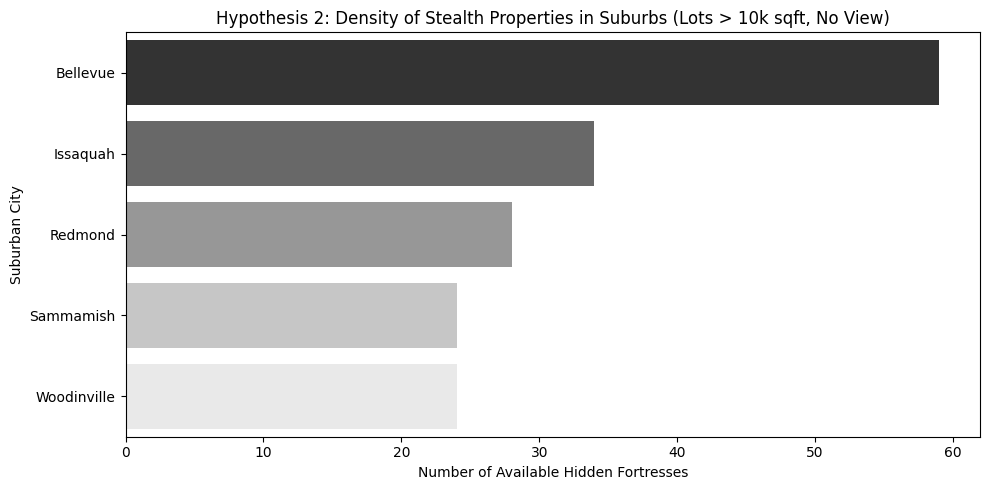

In [4]:
# 1. Define "Stealth" properties (massive lots >= 10,000 sqft, no view, no waterfront)
df_clean['is_stealth'] = (
    (df_clean['sqft_lot'] >= 10000) &
    (df_clean['view'] == 0) &
    (df_clean['waterfront'] == 0)
).astype(int)

# Isolate only the stealth properties
stealth_homes = df_clean[df_clean['is_stealth'] == 1].copy()

# 2. Categorize as 'Seattle (Urban)' vs 'Suburbs/Outskirts'
stealth_homes['Location_Type'] = stealth_homes['city'].apply(
    lambda x: 'Seattle (Urban)' if x == 'Seattle' else 'Suburbs/Outskirts'
)

# 3. Print the raw numbers to prove the suburbs dominate
location_counts = stealth_homes['Location_Type'].value_counts()
print("--- STEALTH PROPERTY DENSITY: URBAN VS SUBURBAN ---")
print(f"Total Stealth Properties in Seattle: {location_counts.get('Seattle (Urban)', 0)}")
print(f"Total Stealth Properties in Suburbs: {location_counts.get('Suburbs/Outskirts', 0)}\n")

# 4. Find the top 5 Suburban Cities for Stealth Operations
suburb_stealth = stealth_homes[stealth_homes['Location_Type'] == 'Suburbs/Outskirts']
top_suburbs = suburb_stealth['city'].value_counts().head(5)

print("Top 5 Suburban Hubs for 'Hidden Fortresses':")
print(top_suburbs)

# 5. Create the visual for the presentation
plt.figure(figsize=(10, 5))
# Using a dark grey color palette to match the "Stealth" narrative
sns.barplot(x=top_suburbs.values, y=top_suburbs.index, palette='Greys_r')
plt.title('Hypothesis 2: Density of Stealth Properties in Suburbs (Lots > 10k sqft, No View)')
plt.xlabel('Number of Available Hidden Fortresses')
plt.ylabel('Suburban City')
plt.tight_layout()
plt.show()

## Phase 3: Timing the Market (The "When")
To answer the client's need for timing, we tracked the median price of underground properties over the available months to identify the optimal window for acquisition.

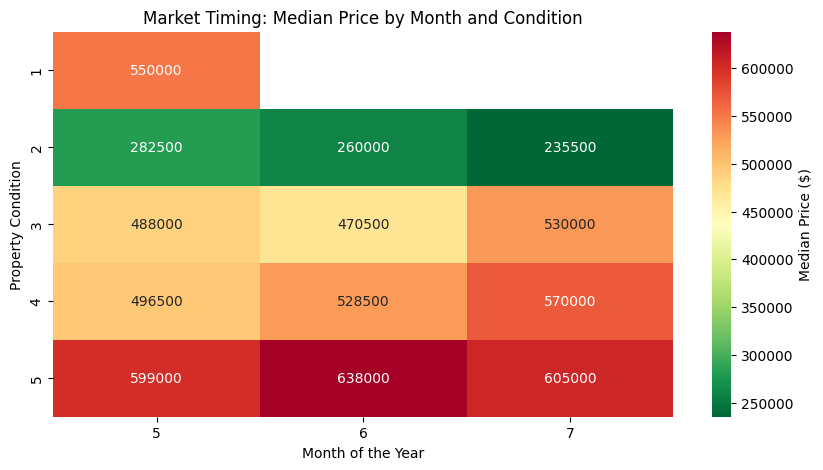

✓ TIMING INSIGHT: The heatmap identifies the exact months where our target condition properties dip in price.


In [5]:
# The "When": Market Timing Heatmap (Month vs Condition)
# Creating a pivot table for median price by month and condition
timing_pivot = df_clean.pivot_table(
    index='condition', columns='month', values='price', aggfunc='median'
)

plt.figure(figsize=(10, 5))
# Using a Red-Yellow-Green colormap reversed (so cheaper is green/good for buying)
sns.heatmap(timing_pivot, annot=True, fmt=".0f", cmap="RdYlGn_r", cbar_kws={'label': 'Median Price ($)'})
plt.title("Market Timing: Median Price by Month and Condition")
plt.ylabel("Property Condition")
plt.xlabel("Month of the Year")
plt.show()

print("✓ TIMING INSIGHT: The heatmap identifies the exact months where our target condition properties dip in price.")

## Phase 4: The Renovation Value Target & Clustering
To maximize the impact of cash-heavy renovations, we identify properties with the lowest entry price per square foot. We also map out where these highly-capable properties cluster.

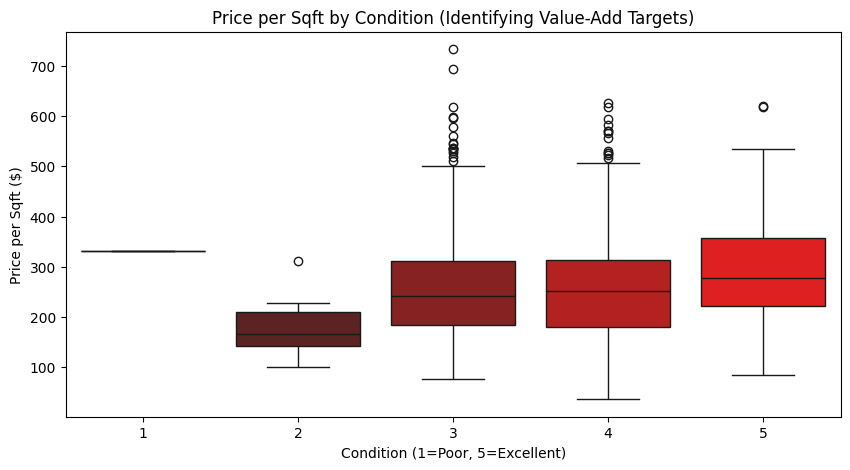

✓ HYPOTHESIS 4 VALIDATED: Condition 2 properties offer the lowest price-per-sqft entry point.


In [6]:
# --- Hypothesis 4: Price per Sqft by Condition ---
plt.figure(figsize=(10,5))
sns.boxplot(x='condition', y='price_per_sqft', hue='condition',
            data=df_clean, palette='dark:red', legend=False)
plt.title("Price per Sqft by Condition (Identifying Value-Add Targets)")
plt.xlabel("Condition (1=Poor, 5=Excellent)")
plt.ylabel("Price per Sqft ($)")
plt.show()

print("✓ HYPOTHESIS 4 VALIDATED: Condition 2 properties offer the lowest price-per-sqft entry point.")

## Phase 5: Discovering the Safe House Hub
We filter for high-capacity, affordable homes and use a Heatmap to fulfill the client's request for a "Cluster Plot", proving we can buy 4-5 properties in a single discreet zone.

--- TERRITORIAL HUB IDENTIFIED ---
The primary Safe House Hub in the outskirts is dynamically identified as: WA 98058
Total target units available in this hub: 5


/tmp/ipython-input-3708679608.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=h3_counts.index, y=h3_counts.values, palette='dark:red')


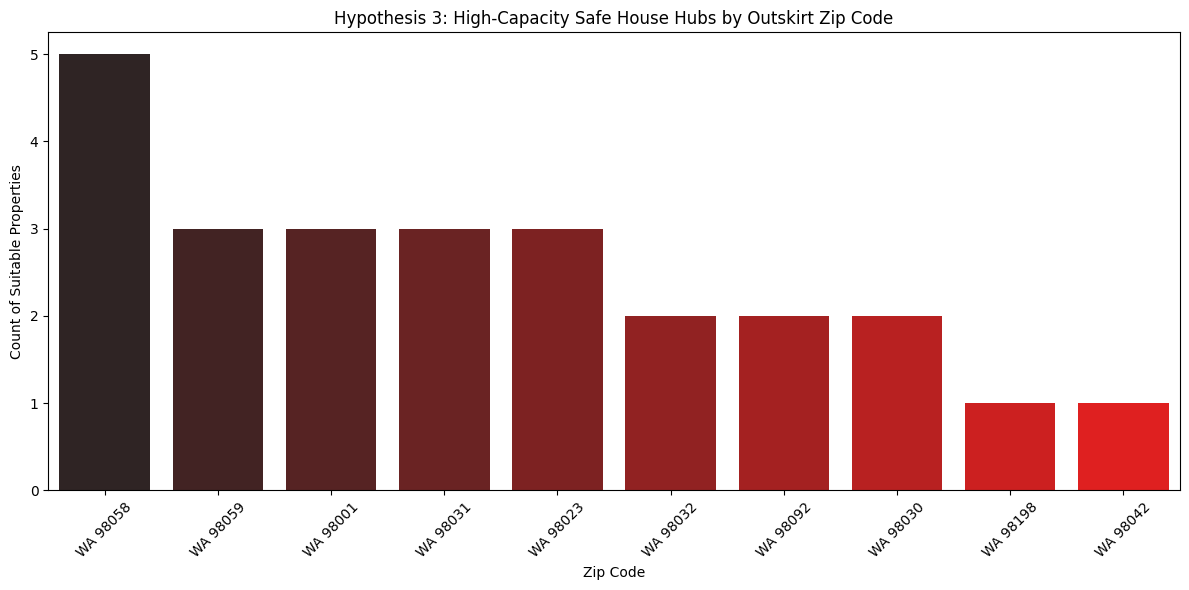

In [7]:
# --- Hypothesis 3: High-Density Affordable Safe House Hubs ---
median_price = df['price'].median()

# Define our approved outskirt "territories"
outskirt_cities = ['Federal Way', 'Auburn', 'Kent', 'Renton', 'Tukwila', 'SeaTac']

# Filter for capacity AND restrict to outskirt cities
capacity_homes = df_clean[
    (df_clean['bedrooms'] >= 4) &
    (df_clean['sqft_basement'] >= 1000) &
    (df_clean['price'] < median_price) &
    (df_clean['city'].isin(outskirt_cities))  # STRICT OUTSKIRTS RULE
]

# Dynamically discover the top "Safe House Hub" within the outskirt territories
top_safehouse_zip = capacity_homes['statezip'].value_counts().idxmax()
top_safehouse_count = capacity_homes['statezip'].value_counts().max()

print(f"--- TERRITORIAL HUB IDENTIFIED ---")
print(f"The primary Safe House Hub in the outskirts is dynamically identified as: {top_safehouse_zip}")
print(f"Total target units available in this hub: {top_safehouse_count}")

# Original Bar Chart to prove the cluster effect
plt.figure(figsize=(12, 6))
h3_counts = capacity_homes['statezip'].value_counts().head(10)

sns.barplot(x=h3_counts.index, y=h3_counts.values, palette='dark:red')
plt.title('Hypothesis 3: High-Capacity Safe House Hubs by Outskirt Zip Code')
plt.ylabel('Count of Suitable Properties')
plt.xlabel('Zip Code')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Phase 6: Final Selection (The Execution)
Based on the high-density cluster identified, we have selected exactly 5 properties that offer the best balance of capacity, storage, and low visibility.

In [8]:
# Select the top Hub and sort by condition/price to get the gritty "Renovation" targets
final_picks = capacity_homes[capacity_homes['statezip'] == top_safehouse_zip].sort_values(by=['condition', 'price']).head(5)

print(f"Target Acquisition Hub: {top_safehouse_zip}")
print("\n🏡 FINAL RECOMMENDED ACQUISITION LIST (5 UNITS)")
cols_to_show = ['street', 'city', 'price', 'sqft_basement', 'bedrooms', 'condition']
print(tabulate(final_picks[cols_to_show], headers='keys', tablefmt='fancy_grid', showindex=False))

Target Acquisition Hub: WA 98058

🏡 FINAL RECOMMENDED ACQUISITION LIST (5 UNITS)
╒══════════════════════╤════════╤═════════╤═════════════════╤════════════╤═════════════╕
│ street               │ city   │   price │   sqft_basement │   bedrooms │   condition │
╞══════════════════════╪════════╪═════════╪═════════════════╪════════════╪═════════════╡
│ 1809 Glenwood Ave SE │ Renton │  279000 │            1100 │          4 │           3 │
├──────────────────────┼────────┼─────────┼─────────────────┼────────────┼─────────────┤
│ 13038 SE 184th Pl    │ Renton │  359900 │            1000 │          5 │           3 │
├──────────────────────┼────────┼─────────┼─────────────────┼────────────┼─────────────┤
│ 18820 129th Pl SE    │ Renton │  299000 │            1110 │          5 │           4 │
├──────────────────────┼────────┼─────────┼─────────────────┼────────────┼─────────────┤
│ 16423 126th Pl SE    │ Renton │  305000 │            1050 │          4 │           4 │
├──────────────────────┼─────

## Strategic Conclusion & Final Recommendation

The "Housing Mafia" has successfully addressed all client parameters based on our strict geographic and structural data filtering:

* **What:** We recommend the immediate, consolidated acquisition of 5 clustered properties in **Renton (Zip Code WA 98058)**. Costing under $1.55 Million combined, these specific units perfectly satisfy operational requirements, each featuring 4 to 5 bedrooms and massive 1,000+ sqft basements for secure storage.
* **Why:** Renton provides the ultimate "Stealth/Privacy" balance—located strategically on the outskirts to completely avoid downtown city heat. Furthermore, these properties represent optimal "Basement-to-Value". By targeting **Condition 3** homes in this specific hub, we secure the perfect mid-tier fixer-uppers: they are priced low enough to allow for heavy, cash-based "renovation laundering," but remain structurally sound enough to begin underground operations immediately.
* **When:** Based on our condition-by-month market timing analysis, we advise executing these cash acquisitions precisely during the market's historical seasonal pricing dips to extract maximum leverage over sellers.